In [2]:
#from sklearn import linear_model
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc

In [3]:
class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=1, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            self.acceleration = nn.Parameter(tc.randn(N_of_paramater))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x


# Oscilador harmonico amortecido

Equaçao diferencial:
$$
\frac{{d^2x}}{{dt^2}} + \gamma\frac{{dx}}{{dt}} + \omega^2 x = 0
$$

$ \gamma = b/m $, b é a constante de amortecimento e $ \omega = \sqrt{k/m }$ omega é a frequencia de oscilação em termo de k=constante da mola e m=massa.

A solução geral para a equação do oscilador harmônico amortecido é dada por:

$$
x(t) = A e^{-\gamma t/2} \cos(\omega_d t + \phi)
$$

Onde:
- \( $A$ \) é a amplitude da oscilação,
- \( $\gamma = \frac{b}{m}$ \) é a taxa de amortecimento,
- \( $\omega_d = \sqrt{\omega^2 - \gamma^2}$ \) é a frequência angular amortecida, e
- \( $\phi$ \) é a fase inicial.

A frequência angular natural $\omega_0 $ é dada por $\omega_0 = \sqrt{\frac{k}{m}}$. Esta solução leva em consideração os casos de amortecimento subamortecido \($ \gamma < \omega_0$ \), superamortecido \( $\gamma > \omega_0 $\) e criticamente amortecido \( $\gamma = \omega_0 $\).


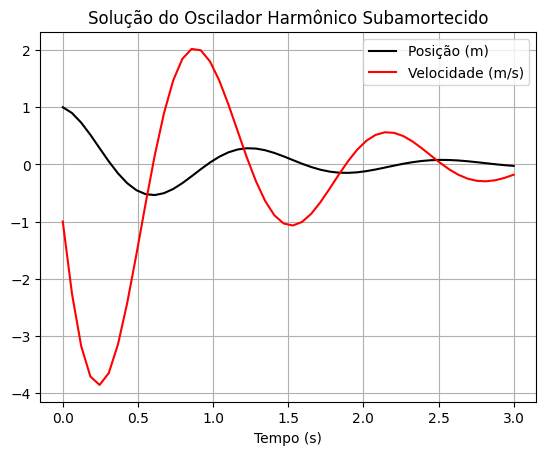

In [3]:
def soluçao_OHM(omega_0,gamma,t):
    omega_0 = tc.tensor(omega_0)
    gamma = tc.tensor(gamma)
    phi_0 = 0#tc.arctan(-2*tc.sqrt(omega_0**2- gamma**2/4)/gamma)
    return tc.exp(-gamma*t/2) * tc.cos(tc.sqrt(omega_0**2- gamma**2/4)* t +phi_0 )
# Criando os dados de treino
t_train = tc.linspace(0,3,50,requires_grad=True).reshape(-1,1)
y_train = soluçao_OHM(omega_0=5,gamma=2,t=t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]

# Plotar a posição em função do tempo
plt.plot(t_train.detach().numpy(), y_train.detach().numpy(),"k-",label='Posição (m)')
plt.plot(t_train.detach().numpy(), v_train.detach().numpy(),"r-",label='Velocidade (m/s)')
plt.xlabel('Tempo (s)')
plt.title('Solução do Oscilador Harmônico Subamortecido')
plt.grid(True)
plt.legend()
plt.show()


In [4]:
# Criando os dados de treino
t_train = tc.linspace(0,3,100,requires_grad=True).reshape(-1,1)
y_train = soluçao_OHM(omega_0=5,gamma=2,t=t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]


t_test = tc.linspace(0,3,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(omega_0=5,gamma=2,t=t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs=tc.ones_like(y_test), create_graph=True)[0]

model = Regressao_M(neuronio = 15,M=2,output=2, activation=SineActivation(),creat_p = True,N_of_paramater = 2)
opt = tc.optim.Adam(params=model.parameters(),lr=0.001,betas=(0.9,0.999))
icx = tc.tensor(1)
icv = tc.tensor(-1)

print(f"| g0:{model.acceleration.detach()}")

LOSS = []
LOSS2 = []
for epoch in range(30000):
    model.train()

    y_preds = model(t_train)
    solution_x = y_preds[:,0].reshape(-1,1) # posição 
    solution_v = y_preds[:,1].reshape(-1,1)     # velocidade 

    paramater = model.acceleration  # 
    omega = paramater[0]
    zeta  = paramater[1]
    ###########################################################################
    dxdt = tc.autograd.grad(solution_x,t_train, grad_outputs=tc.ones_like(solution_x), create_graph=True)[0]
    dvdt = tc.autograd.grad(dxdt, t_train, grad_outputs=tc.ones_like(dxdt), create_graph=True)[0]

    # Edo
    loss_ode_dydt = tc.sum( (dxdt - v_train)**2 ) # d

    # Edo
    loss_ode_dvdt = tc.sum( (dvdt + zeta*dxdt + omega**2*solution_x)**2 )

    # Usando os dado experimentais
    loss_datax = tc.mean( (solution_x - y_train )**2 )
    loss_datav = tc.mean( (solution_v - v_train )**2 )

    # Condição inicial x0
    loss_icx = (solution_x[0] - icx)**2

    # Condição inicial v0
    loss_icv = (dxdt[0] - icv)**2 #+ (solution_v[0] - icv)**2)/2

    loss = loss_icv + loss_icx + loss_datax+ loss_datav + loss_ode_dvdt +loss_ode_dydt
    ############################################################################

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    if epoch % 100 == 0 :
        y_preds_test = model(t_test)
        solution_x = y_preds_test[:,0].reshape(-1,1)
        loss2 = tc.sum((solution_x - y_test)**2)
        LOSS2.append(loss2.detach().numpy())
        LOSS.append(loss.detach().numpy())


| g0:tensor([-1.1447,  0.9825])


| Train Loss: tensor([0.0244]) | g:tensor([-4.9997,  1.9984])


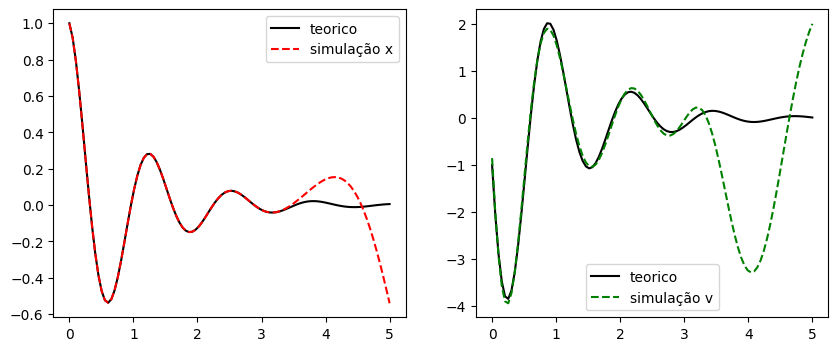

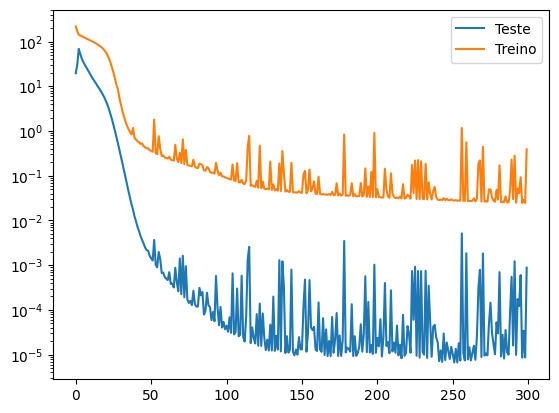

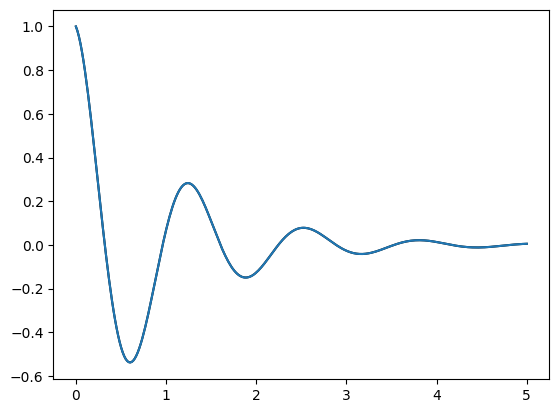

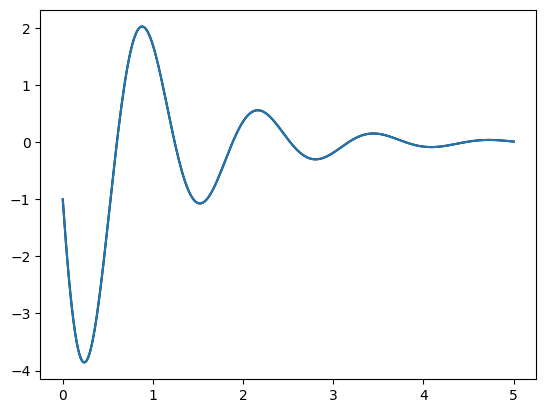

In [5]:
t_test = tc.linspace(0,5,100,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(omega_0=5,gamma=2,t=t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs=tc.ones_like(y_test), create_graph=True)[0]

y_preds_test = model(t_test)
solution_x = y_preds_test[:,0].reshape(-1,1)
solution_v = y_preds_test[:,1].reshape(-1,1)

print(f"| Train Loss: {loss.detach()} | g:{model.acceleration.detach()}")

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="teorico")
ax[0].plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"simulação x" )
ax[0].legend()

ax[1].plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="teorico")
ax[1].plot(t_test.detach().numpy(), solution_v.detach().numpy(),"g--", label=f"simulação v" )
ax[1].legend()
plt.show()
plt.plot(LOSS2,label="Teste")
plt.plot(LOSS,label="Treino")
plt.legend()
plt.yscale('log')
plt.show()
# ####################Plottd com os parametros
w = model.acceleration.detach().numpy()[0]
gma= model.acceleration.detach().numpy()[1]

t_test = tc.linspace(0,5,300,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(omega_0=5,gamma=2,t=t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs=tc.ones_like(y_test), create_graph=True)[0]

y = soluçao_OHM(omega_0=float(w),gamma=float(gma),t=t_test)
v = tc.autograd.grad(y,t_test, grad_outputs=tc.ones_like(y), create_graph=True)[0]

plt.plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="teorico")
plt.plot(t_test.detach().numpy(), y.detach().numpy())
plt.show()

plt.plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="teorico")
plt.plot(t_test.detach().numpy(),v.detach().numpy())

plt.show()

# Oscilador harmonico Simples

$$

\frac{{d^2x}}{{dt^2}} + \omega_0^2 x =0

$$

$ \omega_0 = \sqrt{k/m }$ omega é a frequencia de oscilação em termo de k=constante da mola e m=massa. Solução considerando v(0)=0 e x(0)=x_0:


$$
x(t) = x_0cos(w_0t) 
$$

In [4]:
def soluçao_OHM(x_0,omega_0,t):
    x_0_ = tc.tensor(x_0)
    return x_0_*tc.cos(tc.tensor(omega_0)*t)

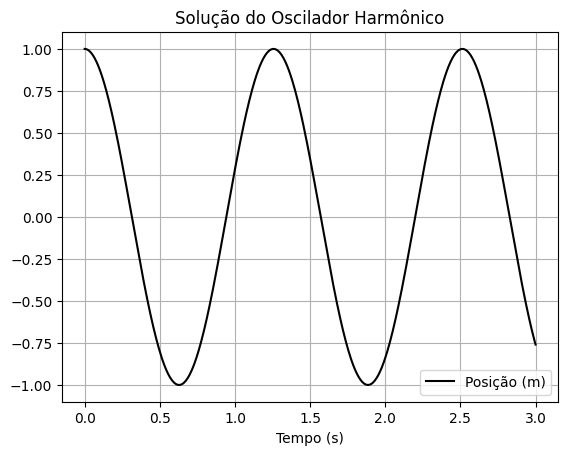

In [7]:
# Criando os dados de treino
t_train = tc.linspace( 0, 3, 500, requires_grad = True).reshape(-1,1)
y_train = soluçao_OHM(x_0 = 1,omega_0 = 5,t = t_train)
v_train = tc.autograd.grad( y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]


# Plotar a posição em função do tempo
plt.plot(t_train.detach().numpy(), y_train.detach().numpy(),"k-",label='Posição (m)')
#plt.plot(t_train.detach().numpy(), v_train.detach().numpy(),"r-",label='Velocidade (m/s)')
plt.xlabel('Tempo (s)');plt.title('Solução do Oscilador Harmônico')
plt.grid(True);plt.legend();plt.show()

### Aprendendo a função sabendo os parametros

In [11]:
x_0 = 1
x_i = 0
x_f = 2
Omega_0 = 4

# Criando os dados de treino
t_train = tc.linspace( x_i, x_f, 100, requires_grad = True).reshape(-1,1)
y_train = soluçao_OHM( x_0 = x_0, omega_0 = Omega_0 , t = t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]

t_test = tc.linspace(x_i,x_f,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(x_0 = x_0 ,omega_0 = Omega_0 ,t = t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs = tc.ones_like(y_test),create_graph = True)[0]

model = Regressao_M(neuronio = 15,M=2,output=2, activation=SineActivation())
opt = tc.optim.Adam(params=model.parameters(),lr=0.001)
icx = tc.tensor([x_0])
icv = tc.tensor([0])

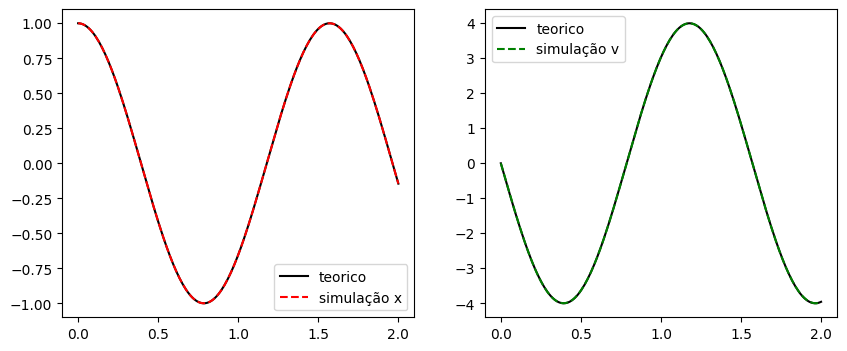

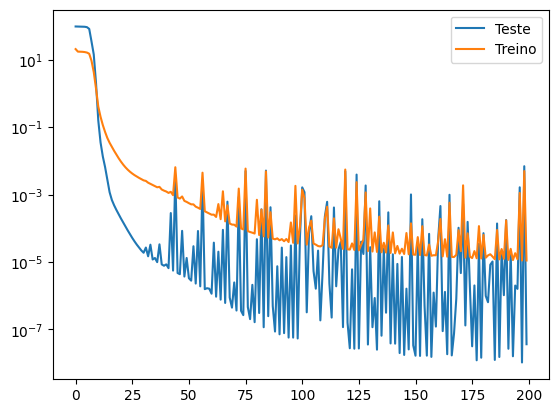

In [12]:
LOSS = []
LOSS2 = []
for epoch in range(20000):
    model.train()

    y_preds = model(t_train)
    solution_x = y_preds[:,0].reshape(-1,1)
    solution_v = y_preds[:,1].reshape(-1,1)

    ###########################################################################
    dxdt = tc.autograd.grad(solution_x,t_train, grad_outputs=tc.ones_like(solution_x), create_graph=True)[0]
    dvdt = tc.autograd.grad(dxdt, t_train, grad_outputs=tc.ones_like(dxdt), create_graph=True)[0]

    # Edo
    loss_ode_dxdt = tc.mean( (dxdt - v_train)**2 )
    loss_ode_dvdt = tc.mean( (dvdt + Omega_0**2*solution_x )**2 )

    # Usando os dado experimentais
    loss_datax = tc.mean( (solution_x - y_train )**2 )
    loss_datav = tc.mean( (solution_v - v_train )**2 )

    # Condição inicial x0
    loss_icx = (solution_x[0] - icx)**2

    # Condição inicial v0
    loss_icv = ((dxdt[0] - icv)**2 + (solution_v[0] - icv)**2)/2

    loss = loss_icv + loss_icx + loss_datax+ loss_datav + loss_ode_dvdt +loss_ode_dxdt
    #loss = loss_datax+ loss_datav + loss_ode_dvdt +loss_ode_dxdt
    ############################################################################

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    if epoch % 100 == 0 :
        y_preds_test = model(t_test)
        solution_x = y_preds_test[:,0].reshape(-1,1)
        loss2 = tc.sum((solution_x - y_test)**2)
        LOSS2.append(loss2.detach().numpy())
        LOSS.append(loss.detach().numpy())

y_preds_test = model(t_test)
solution_x = y_preds_test[:,0].reshape(-1,1)
solution_v = y_preds_test[:,1].reshape(-1,1)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="teorico")
ax[0].plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"simulação x" )
ax[0].legend()

ax[1].plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="teorico")
ax[1].plot(t_test.detach().numpy(), solution_v.detach().numpy(),"g--", label=f"simulação v" )
ax[1].legend()
plt.show()

plt.plot(LOSS2,label="Teste")
plt.plot(LOSS,label="Treino")
plt.legend()
plt.yscale('log')
plt.show()


In [ ]:
# ####################Plottd com os parametros
# omega_0_p = model.acceleration.detach().numpy()[0]
# omega_p= model.acceleration.detach().numpy()[1]

# t_test = tc.linspace(0,5,300,requires_grad=True).reshape(-1,1)
# y_test = soluçao_OHM(x_0=x_0,f_0=F_0,omega_0=5,omega=6.5,t=t_test)
# v_test = tc.autograd.grad(y_test,t_test, grad_outputs=tc.ones_like(y_test), create_graph=True)[0]

# y = soluçao_OHM(x_0=x_0,f_0=F_0,omega_0=omega_0_p,omega=omega_p,t=t_test)
# v = tc.autograd.grad(y,t_test, grad_outputs=tc.ones_like(y), create_graph=True)[0]

# plt.plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="teorico")
# plt.plot(t_test.detach().numpy(), y.detach().numpy(),"r--", label="simulaçao")
# plt.legend()
# #plt.grid(True)
# plt.show()

# plt.plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="teorico")
# plt.plot(t_test.detach().numpy(),v.detach().numpy(),"r--", label="simulaçao")
# #plt.grid(True)
# plt.legend()
# plt.show()

### Aprendendo os parametros

In [28]:
x_0 = 1
x_i = 0
x_f = 3
Omega_0 = 5

# Criando os dados de treino
t_train = tc.linspace( x_i, x_f, 100, requires_grad = True).reshape(-1,1)
y_train = soluçao_OHM( x_0 = x_0, omega_0 = Omega_0, t = t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]

t_test = tc.linspace(x_i,x_f,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(x_0 = x_0 ,omega_0 = Omega_0  ,t = t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs = tc.ones_like(y_test),create_graph = True)[0]

model = Regressao_M(neuronio = 5,M=2,output=1, activation=SineActivation(),creat_p=True,N_of_paramater=1)
opt = tc.optim.Adam(params=model.parameters(),lr=0.01)
icx = tc.tensor([x_0])
icv = tc.tensor([0])
print(model.acceleration[0])

tensor(0.9388, grad_fn=<SelectBackward0>)


tensor(5.0813, grad_fn=<SelectBackward0>)


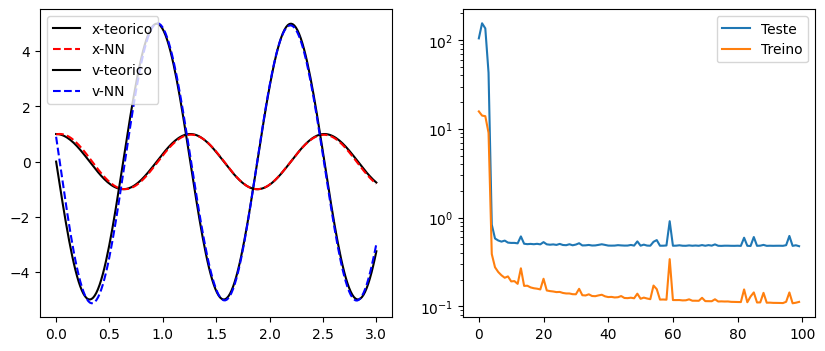

In [29]:
LOSS = []
LOSS2 = []
for epoch in range(10000):
    model.train()
    solution_x = model(t_train)

    ###########################################################################
    dxdt = tc.autograd.grad(solution_x,t_train, grad_outputs=tc.ones_like(solution_x), create_graph=True)[0]
    dvdt = tc.autograd.grad(dxdt, t_train, grad_outputs=tc.ones_like(dxdt), create_graph=True)[0]

    # Edo
    loss_ode_dxdt = tc.mean( (dxdt - v_train)**2 )
    loss_ode_dvdt = tc.mean( (dvdt + solution_x*(model.acceleration[0])**2 )**2 )

    # Usando os dado experimentais
    loss_datax = tc.mean( (solution_x - y_train )**2 )

    # Condição inicial x0 e v0
    loss_icx = (solution_x[0] - icx)**2 + (dxdt[0] - icx)**2

    loss = loss_icx + loss_datax + loss_ode_dvdt/(abs(model.acceleration[0]))  + loss_ode_dxdt
    ############################################################################

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    if epoch % 100 == 0 :
        solution_x = model(t_test)
        
        loss2 = tc.sum((solution_x - y_test)**2)
        LOSS2.append(loss2.detach().numpy())
        LOSS.append(loss.detach().numpy())
        
print(model.acceleration[0])

t_test = tc.linspace(x_i,x_f,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(x_0 = x_0 ,omega_0 = Omega_0  ,t = t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs = tc.ones_like(y_test),create_graph = True,allow_unused=True)[0]


solution_x = model(t_test)
solution_v = tc.autograd.grad(solution_x,t_test, grad_outputs=tc.ones_like(solution_x), create_graph=True,allow_unused=True)[0]
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="x-teorico")
ax[0].plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"x-NN" )

ax[0].plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="v-teorico")
ax[0].plot(t_test.detach().numpy(), solution_v.detach().numpy(),"b--", label=f"v-NN" )


ax[0].legend()
ax[1].plot(LOSS2,label="Teste")
ax[1].plot(LOSS,label="Treino")
ax[1].legend()
plt.yscale('log')
plt.show()


# Oscilador harmonico forçado

$$

\frac{{d^2x}}{{dt^2}} + \omega_0^2 x = F(t)/m

$$

$ \gamma = b/m $, b é a constante de amortecimento e $ \omega_0 = \sqrt{k/m }$ omega é a frequencia de oscilação em termo de k=constante da mola e m=massa.

$$
F(t) = F_{0} cos(wt )
$$

$w$ é a frequência angular da força diretriz.


Solução consideranod v(0)=0 e x(0)=x_0:


$$
x(t) = x_0cos(w_0t) + F_0*\frac{cos(wt)- cos(w_0t) }{w_0^2-w^2 }
$$

In [ ]:
def soluçao_OHM(x_0,f_0,omega_0,omega,t):
    x_0_ = tc.tensor(x_0)
    f_0_ = tc.tensor(f_0)
    omega_0_ = tc.tensor(omega_0)
    omega_ = tc.tensor(omega)
    
    return x_0_*tc.cos(omega_0_*t) +f_0_*( tc.cos(omega_*t)- tc.cos(omega_0_*t) )/(omega_0_**2 - omega_**2 )

In [ ]:
# Criando os dados de treino
t_train = tc.linspace(0,2,500,requires_grad=True).reshape(-1,1)
y_train = soluçao_OHM(x_0=1,f_0=1,omega_0=4,omega=2,t=t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]
# Plotar a posição em função do tempo
plt.plot(t_train.detach().numpy(), y_train.detach().numpy(),"k-",label='Posição (m)')
plt.plot(t_train.detach().numpy(), v_train.detach().numpy(),"r-",label='Velocidade (m/s)')
plt.xlabel('Tempo (s)');plt.title('Solução do Oscilador Harmônico')
plt.grid(True);plt.legend();plt.show()